In [4]:
#Mendownload dataset
!gdown 1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv -O data/dataset.zip

#Melakukan unzip file dataset
!unzip -q data/dataset.zip -d data/

#Menghapus file zip
!rm -rf data/dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv
From (redirected): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv&confirm=t&uuid=4edf6612-1ca1-40f0-a51f-49249e6c0f54
To: /workspace/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/data/dataset.zip
100%|████████████████████████████████████████| 864M/864M [00:10<00:00, 79.3MB/s]


In [5]:
!python example.py

Pemisahan file gambar berdasarkan class selesai!
split_dataset_utama done
Pemisahan dan penggabungan file gambar dari data/ROOT/train dan data/ROOT/test berdasarkan class selesai!
split_dataset_utama_versi_submission done
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
split_utama done
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
split_utama_versi_submission done
Class 'Black Rot' telah dibagi ke dalam train, val, dan test.
Class 'Cedar Rust' telah dibagi ke dalam train, val, dan test.
Class 'Healthy' telah dibagi ke dalam train, val, dan test.


In [7]:
# Import library yang digunakan untuk keseluruhan dataset
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Import model arsitektur dan preprocess input untuk MobileNet dan EfficientNet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

In [8]:
# Daftar model EfficientNet yang akan dihitung jumlah layernya
efficientnet_variants = [
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
]

# List untuk menyimpan hasil jumlah layer
model_layers_count = []

# Loop melalui setiap varian dan hitung jumlah layer
for variant in efficientnet_variants:
    model_name = variant.__name__  # Mendapatkan nama model
    model = variant(weights='imagenet')  # Menggunakan weights 'imagenet'
    layer_count = len(model.layers)  # Menghitung jumlah layer
    model_layers_count.append((model_name, layer_count))  # Menyimpan hasil ke list

# Membuat dataframe dari hasil yang diperoleh
df_layers = pd.DataFrame(model_layers_count, columns=['Model', 'Number of Layers'])

# Menampilkan tabel jumlah layer
print(df_layers)

2024-10-05 15:11:10.063314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


268326632/268326632 [==============================] - 2s 0us/step
            Model  Number of Layers
0  EfficientNetB0               241
1  EfficientNetB1               343
2  EfficientNetB2               343
3  EfficientNetB3               388
4  EfficientNetB4               478
5  EfficientNetB5               580
6  EfficientNetB6               670
7  EfficientNetB7               817


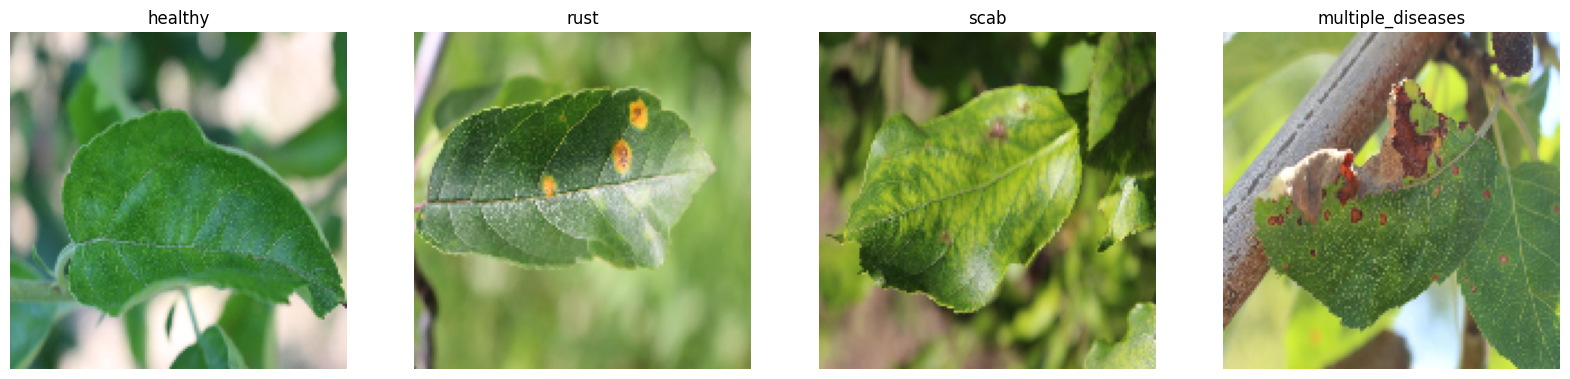

In [9]:
# Menampilkan gambar per kelas
base_path = 'data/original_dataset_utama/train'

classes = ['healthy','rust', 'scab', 'multiple_diseases']
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(class_name)

plt.show()

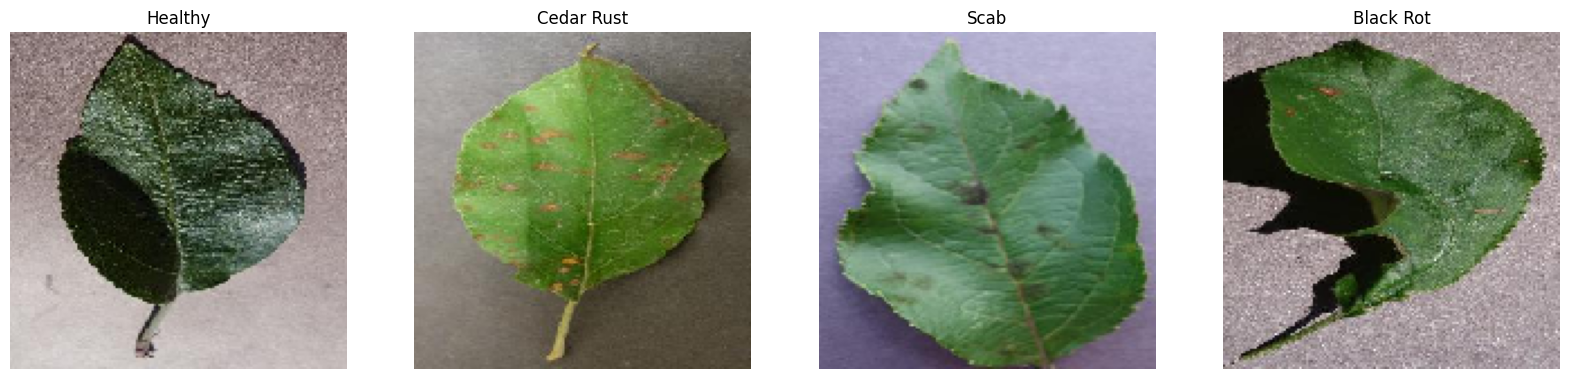

In [11]:
# Menampilkan gambar per kelas
base_path = 'data/original_dataset_cadangan'

classes = ['Healthy', 'Cedar Rust', 'Scab', 'Black Rot']
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(class_name)

plt.show()

In [19]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [20]:
def build_and_compile_model_not_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
def build_and_compile_model_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze 85% layer pertama dari base model
    total_layers = len(base_model.layers)
    freeze_layers = int(0.85 * total_layers)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [42]:
# Fungsi untuk melatih model dan menampilkan grafik
def train_and_plot(model, model_name, train_generator, validation_generator, epochs, save_directory):
    # Membuat folder penyimpanan jika belum ada
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Menyusun nama file penyimpanan model dengan parameter model_name
    save_path = os.path.join(save_directory, f'best_model_{model_name}.h5')

    # Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
    checkpoint_callback = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Plotting hasil
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    # Evaluasi model setelah pelatihan
    tes_loss, tes_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {tes_accuracy:.4f}")

    
    # Evaluate and plot confusion matrix
    # Mendapatkan nama kelas
    class_names = list(test_generator.class_indices.keys())

    # Prediksi pada data test
    y_pred = model.predict(test_generator)
    
    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=class_names)
    
    # Menampilkan hasil classification report
    print("Classification Report:\n", cr)

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return history

In [27]:
# # Fungsi untuk melakukan testing dan menampilkan confusion matrix
# def evaluate_and_plot_confusion_matrix(model, test_generator):
#     # Mendapatkan nama kelas
#     class_names = list(test_generator.class_indices.keys())

#     # Prediksi pada data test
#     y_pred = model.predict(test_generator)
    
#     # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
#     y_pred_classes = np.argmax(y_pred, axis=1)
    
#     # Mengambil label sebenarnya dari generator
#     y_true = test_generator.classes

#     # Membuat confusion matrix
#     cm = confusion_matrix(y_true, y_pred_classes)
#     cr = classification_report(y_true, y_pred_classes, target_names=class_names)
    
#     # Menampilkan hasil classification report
#     print("Classification Report:\n", cr)

#     # Plot confusion matrix sebagai heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()

In [28]:
efficientnet_input_shapes = {
    'EfficientNetB0': (224, 224),
    'EfficientNetB1': (240, 240),
    'EfficientNetB2': (260, 260),
    'EfficientNetB3': (300, 300),
    'EfficientNetB4': (380, 380),
    'EfficientNetB5': (456, 456),
    'EfficientNetB6': (528, 528),
    'EfficientNetB7': (600, 600),
}

base_path = "data/split_train_test_dataset_campuran"

preprocess_input_func = efficientnet_preprocess

In [ ]:
#           Model  Total Layers  Freeze Layers  Train Layers
# 0  EfficientNetB0           241            204            37
# 1  EfficientNetB1           343            291            52
# 2  EfficientNetB2           343            291            52
# 3  EfficientNetB3           388            329            59
# 4  EfficientNetB4           478            406            72
# 5  EfficientNetB5           580            493            87
# 6  EfficientNetB6           670            569           101
# 7  EfficientNetB7           817            694           123


Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.6968

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 28s 271ms/step - loss: 0.7093 - accuracy: 0.6968 - val_loss: 0.4252 - val_accuracy: 0.8333
Epoch 2/50
87/87 [==============================] - 23s 266ms/step - loss: 0.4525 - accuracy: 0.8148 - val_loss: 0.4429 - val_accuracy: 0.8075
Epoch 3/50
87/87 [==============================] - 23s 261ms/step - loss: 0.3959 - accuracy: 0.8444 - val_loss: 0.3715 - val_accuracy: 0.8391
Epoch 4/50
87/87 [==============================] - 23s 270ms/step - loss: 0.3447 - accuracy: 0.8683 - val_loss: 0.3335 - val_accuracy: 0.8764
Epoch 5/50
87/87 [==============================] - 23s 269ms/step - loss: 0.3194 - accuracy: 0.8777 - val_loss: 0.3621 - val_accuracy: 0.8592
Epoch 6/50
87/87 [==============================] - 23s 266ms/step - loss: 0.3270 - accuracy: 0.8777 - val_loss: 0.3159 - val_accuracy: 0.8736
Epoch 7/50
87/87 [==============================] - 22s 255ms/step - loss: 0.2891 - accuracy: 0.8944 - val_loss: 0.4037 - val_accuracy: 0.8247
Epoch 8/50

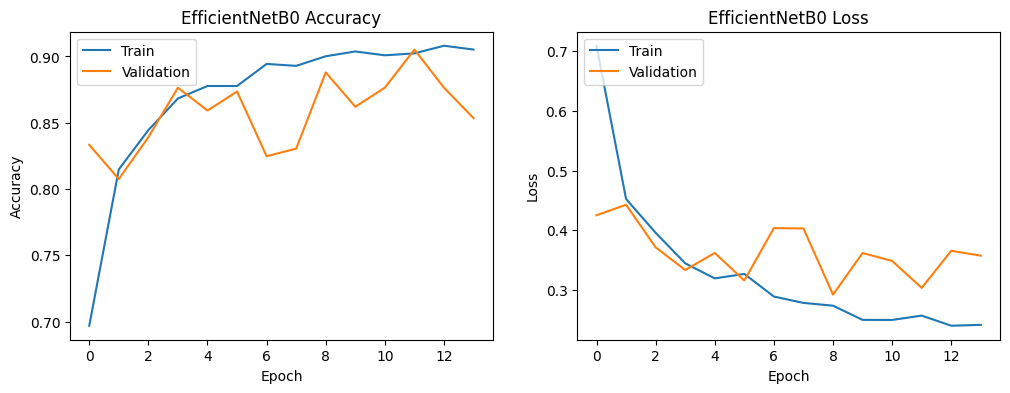

160/160 [==============================] - 4s 14ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.74      1.00      0.85      1645
        rust       0.88      0.25      0.39       275
        scab       0.75      0.30      0.42       630

    accuracy                           0.75      2550
   macro avg       0.79      0.52      0.56      2550
weighted avg       0.76      0.75      0.70      2550



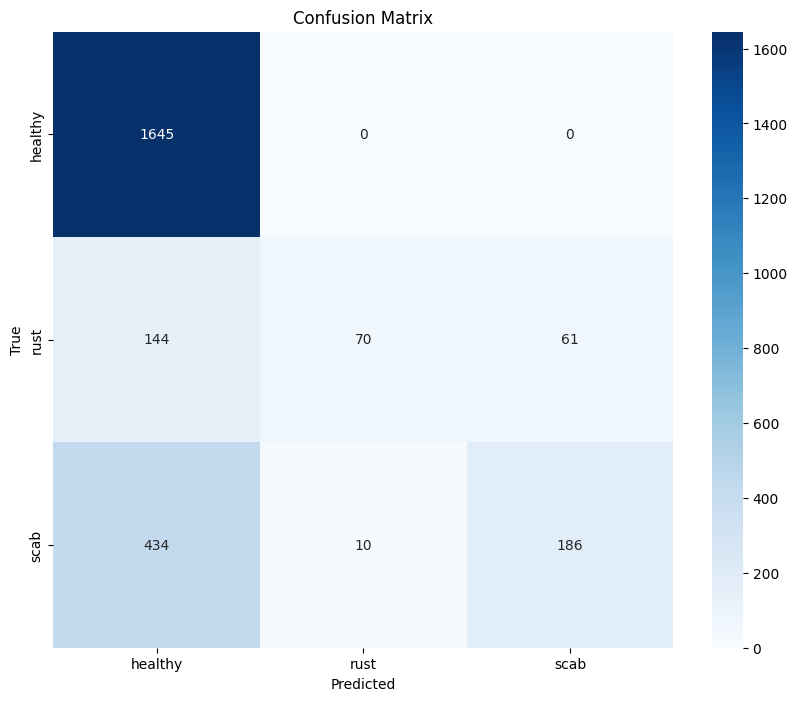

In [31]:
model_name = 'EfficientNetB0'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B0 = build_and_compile_model_not_trainable(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B0 = train_and_plot(EN_B0, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B0, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.6635

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 32s 297ms/step - loss: 0.7615 - accuracy: 0.6635 - val_loss: 0.5009 - val_accuracy: 0.7902
Epoch 2/50
87/87 [==============================] - 25s 282ms/step - loss: 0.4669 - accuracy: 0.8075 - val_loss: 0.4602 - val_accuracy: 0.8046
Epoch 3/50
87/87 [==============================] - 24s 279ms/step - loss: 0.3844 - accuracy: 0.8517 - val_loss: 0.3582 - val_accuracy: 0.8534
Epoch 4/50
87/87 [==============================] - 24s 281ms/step - loss: 0.3807 - accuracy: 0.8531 - val_loss: 0.3371 - val_accuracy: 0.8649
Epoch 5/50
87/87 [==============================] - 24s 271ms/step - loss: 0.3353 - accuracy: 0.8647 - val_loss: 0.3064 - val_accuracy: 0.8764
Epoch 6/50
87/87 [==============================] - 25s 282ms/step - loss: 0.2962 - accuracy: 0.8886 - val_loss: 0.3486 - val_accuracy: 0.8649
Epoch 7/50
87/87 [==============================] - 24s 273ms/step - loss: 0.2958 - accuracy: 0.8813 - val_loss: 0.3503 - val_accuracy: 0.8678
Epoch 8/50

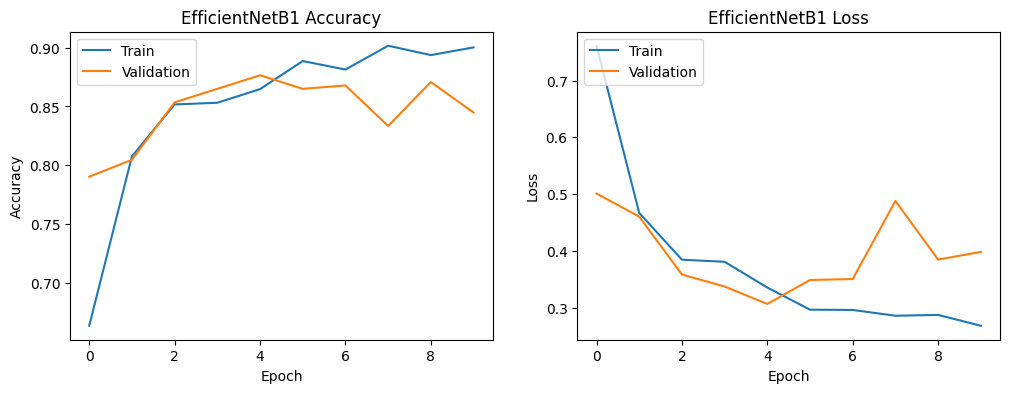

160/160 [==============================] - 4s 17ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.82      0.97      0.89      1645
        rust       0.61      0.75      0.67       275
        scab       0.76      0.33      0.46       630

    accuracy                           0.79      2550
   macro avg       0.73      0.68      0.67      2550
weighted avg       0.78      0.79      0.76      2550



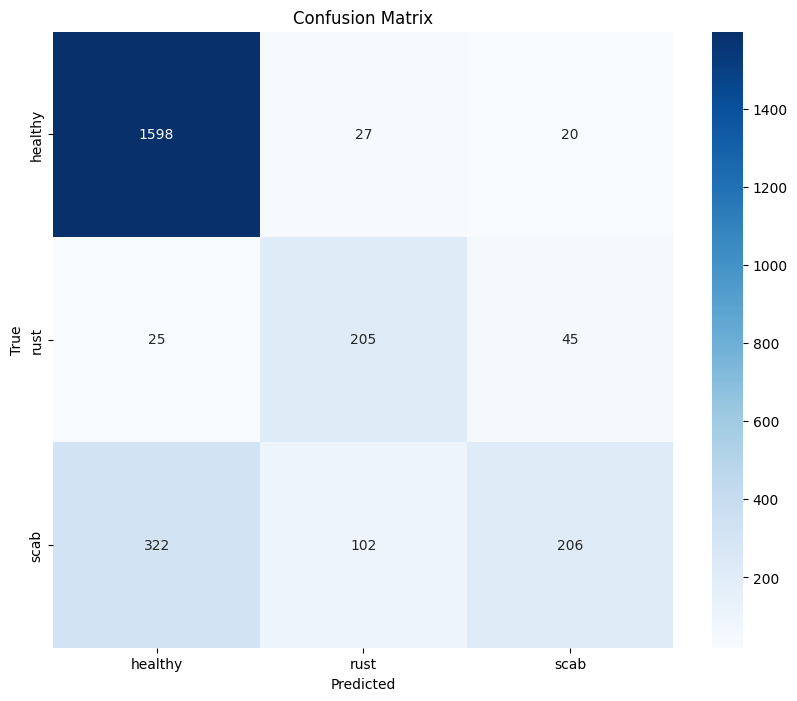

In [32]:
model_name = 'EfficientNetB1'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B1 = build_and_compile_model_not_trainable(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B1 = train_and_plot(EN_B1, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B1, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
31790344/31790344 [==============================] - 0s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.6483

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 34s 315ms/step - loss: 0.7761 - accuracy: 0.6483 - val_loss: 0.4125 - val_accuracy: 0.8362
Epoch 2/50
87/87 [==============================] - 26s 301ms/step - loss: 0.4663 - accuracy: 0.8213 - val_loss: 0.3594 - val_accuracy: 0.8391
Epoch 3/50
87/87 [==============================] - 25s 292ms/step - loss: 0.3819 - accuracy: 0.8560 - val_loss: 0.2761 - val_accuracy: 0.8736
Epoch 4/50
87/87 [==============================] - 26s 295ms/step - loss: 0.3554 - accuracy: 0.8647 - val_loss: 0.3631 - val_accuracy: 0.8448
Epoch 5/50
87/87 [==============================] - 26s 296ms/step - loss: 0.3165 - accuracy: 0.8821 - val_loss: 0.2915 - val_accuracy: 0.8736
Epoch 6/50
87/87 [==============================] - 26s 297ms/step - loss: 0.3105 - accuracy: 0.8763 - val_loss: 0.4048 - val_accuracy: 0.8132
Epoch 7/50
87/87 [==============================] - 26s 295ms/step - loss: 0.2954 - accuracy: 0.8900 - val_loss: 0.3188 - val_accuracy: 0.8621
Epoch 8/50

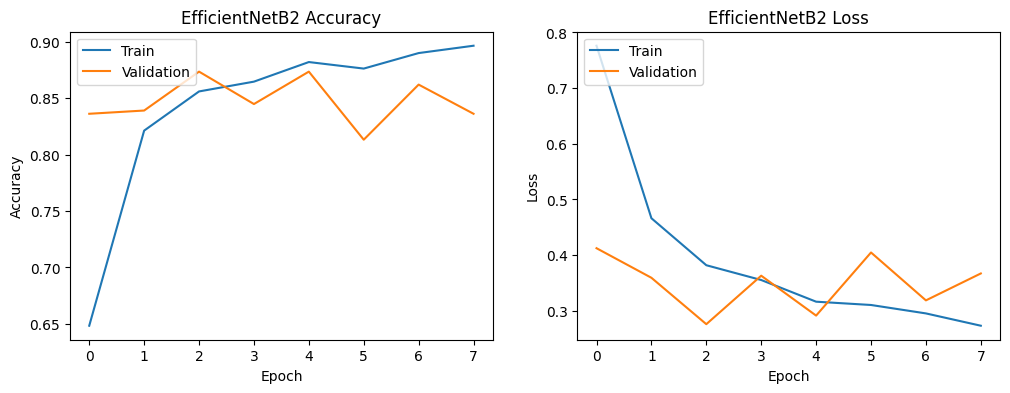

160/160 [==============================] - 5s 20ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.85      0.72      0.78      1645
        rust       0.73      0.15      0.24       275
        scab       0.39      0.68      0.49       630

    accuracy                           0.65      2550
   macro avg       0.66      0.52      0.51      2550
weighted avg       0.73      0.65      0.65      2550



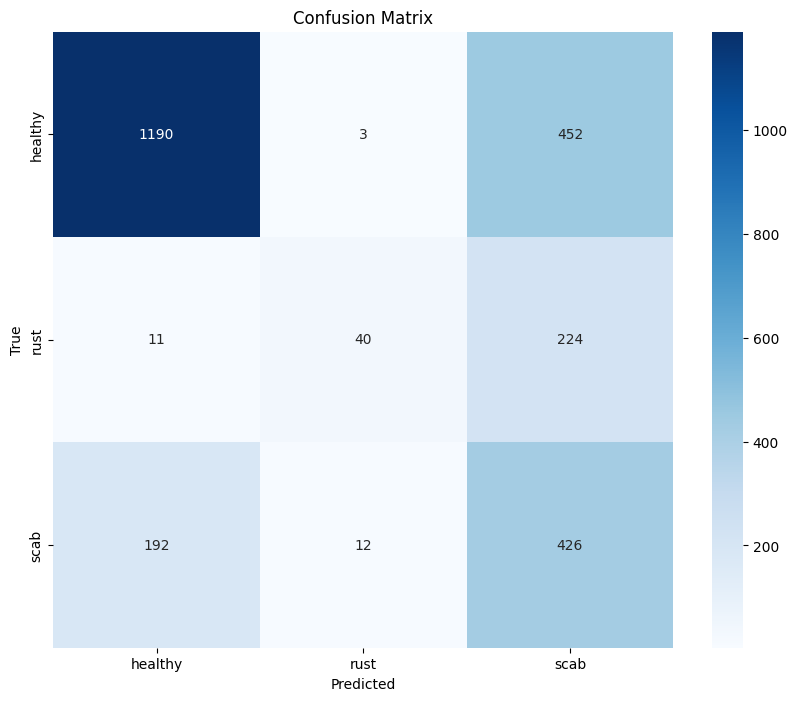

In [33]:
model_name = 'EfficientNetB2'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B2 = build_and_compile_model_not_trainable(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B2 = train_and_plot(EN_B2, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B2, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.6946

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 39s 363ms/step - loss: 0.6979 - accuracy: 0.6946 - val_loss: 0.5256 - val_accuracy: 0.7586
Epoch 2/50
87/87 [==============================] - 30s 348ms/step - loss: 0.4107 - accuracy: 0.8444 - val_loss: 0.3098 - val_accuracy: 0.8764
Epoch 3/50
87/87 [==============================] - 32s 363ms/step - loss: 0.3366 - accuracy: 0.8726 - val_loss: 0.3923 - val_accuracy: 0.8333
Epoch 4/50
87/87 [==============================] - 33s 376ms/step - loss: 0.3504 - accuracy: 0.8661 - val_loss: 0.3140 - val_accuracy: 0.8707
Epoch 5/50
87/87 [==============================] - 33s 384ms/step - loss: 0.2817 - accuracy: 0.8936 - val_loss: 0.4453 - val_accuracy: 0.8448
Epoch 6/50
87/87 [==============================] - 36s 410ms/step - loss: 0.2901 - accuracy: 0.8965 - val_loss: 0.2347 - val_accuracy: 0.9023
Epoch 7/50
87/87 [==============================] - 34s 396ms/step - loss: 0.2498 - accuracy: 0.9052 - val_loss: 0.2556 - val_accuracy: 0.9052
Epoch 8/50

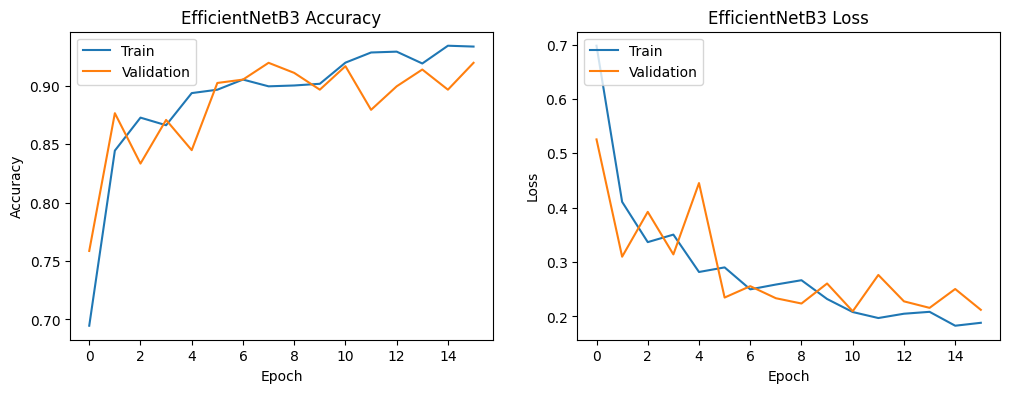

160/160 [==============================] - 5s 20ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.91      0.90      0.91      1645
        rust       0.66      0.37      0.47       275
        scab       0.60      0.73      0.66       630

    accuracy                           0.80      2550
   macro avg       0.72      0.67      0.68      2550
weighted avg       0.81      0.80      0.80      2550



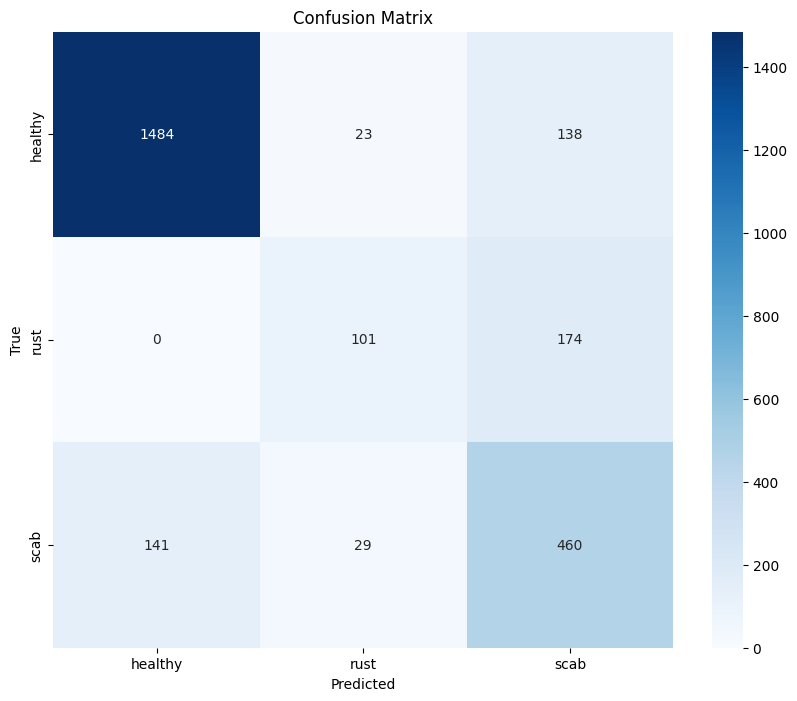

In [34]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_not_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3 = train_and_plot(EN_B3, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B3, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
71686520/71686520 [==============================] - 1s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.7294

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 58s 555ms/step - loss: 0.6396 - accuracy: 0.7294 - val_loss: 0.3668 - val_accuracy: 0.8534
Epoch 2/50
87/87 [==============================] - 44s 504ms/step - loss: 0.3402 - accuracy: 0.8719 - val_loss: 0.2427 - val_accuracy: 0.9109
Epoch 3/50
87/87 [==============================] - 40s 463ms/step - loss: 0.2956 - accuracy: 0.8994 - val_loss: 0.2725 - val_accuracy: 0.8793
Epoch 4/50
87/87 [==============================] - 40s 456ms/step - loss: 0.2378 - accuracy: 0.9088 - val_loss: 0.2713 - val_accuracy: 0.8908
Epoch 5/50
87/87 [==============================] - 48s 552ms/step - loss: 0.2191 - accuracy: 0.9255 - val_loss: 0.2018 - val_accuracy: 0.9253
Epoch 6/50
87/87 [==============================] - 47s 542ms/step - loss: 0.2202 - accuracy: 0.9117 - val_loss: 0.1899 - val_accuracy: 0.9282
Epoch 7/50
87/87 [==============================] - 42s 479ms/step - loss: 0.2007 - accuracy: 0.9305 - val_loss: 0.2133 - val_accuracy: 0.9282
Epoch 8/50

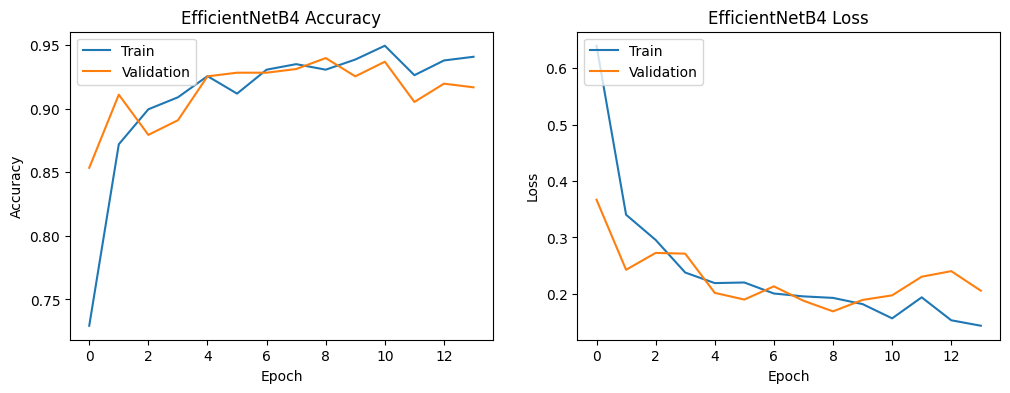

160/160 [==============================] - 9s 42ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.89      0.98      0.93      1645
        rust       0.77      0.06      0.11       275
        scab       0.61      0.68      0.64       630

    accuracy                           0.81      2550
   macro avg       0.76      0.58      0.56      2550
weighted avg       0.81      0.81      0.77      2550



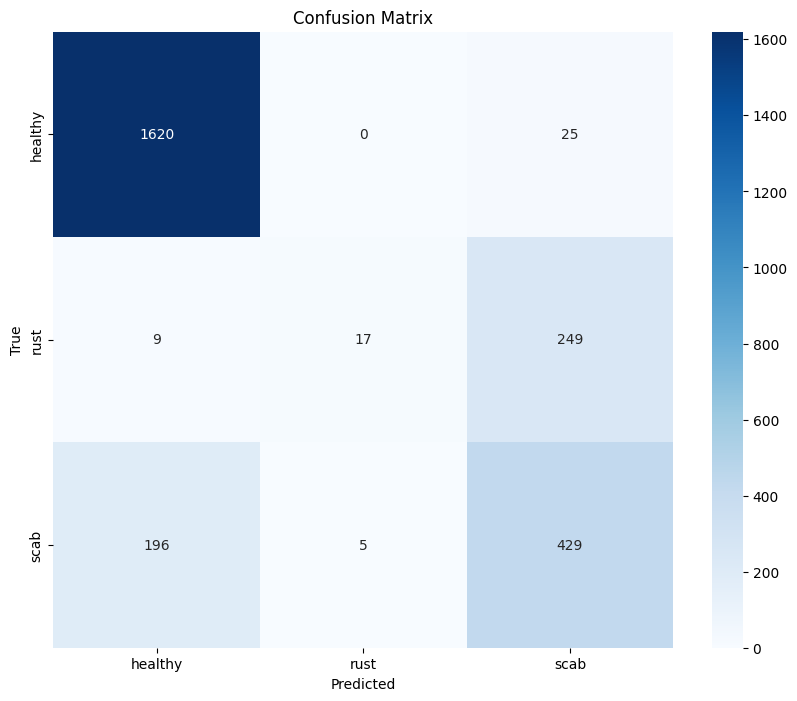

In [35]:
model_name = 'EfficientNetB4'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B4 = build_and_compile_model_not_trainable(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B4 = train_and_plot(EN_B4, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B4, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
115263384/115263384 [==============================] - 1s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.7004

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 71s 695ms/step - loss: 0.6799 - accuracy: 0.7004 - val_loss: 0.3836 - val_accuracy: 0.8420
Epoch 2/50
87/87 [==============================] - 57s 661ms/step - loss: 0.3509 - accuracy: 0.8712 - val_loss: 0.3275 - val_accuracy: 0.8649
Epoch 3/50
87/87 [==============================] - 62s 717ms/step - loss: 0.2691 - accuracy: 0.8987 - val_loss: 0.2566 - val_accuracy: 0.9052
Epoch 4/50
87/87 [==============================] - 64s 735ms/step - loss: 0.2373 - accuracy: 0.9038 - val_loss: 0.2829 - val_accuracy: 0.8879
Epoch 5/50
87/87 [==============================] - 58s 672ms/step - loss: 0.2523 - accuracy: 0.9045 - val_loss: 0.2505 - val_accuracy: 0.9052
Epoch 6/50
87/87 [==============================] - 58s 662ms/step - loss: 0.1892 - accuracy: 0.9284 - val_loss: 0.3108 - val_accuracy: 0.8937
Epoch 7/50
87/87 [==============================] - 66s 760ms/step - loss: 0.1879 - accuracy: 0.9255 - val_loss: 0.3441 - val_accuracy: 0.8851
Epoch 8/50

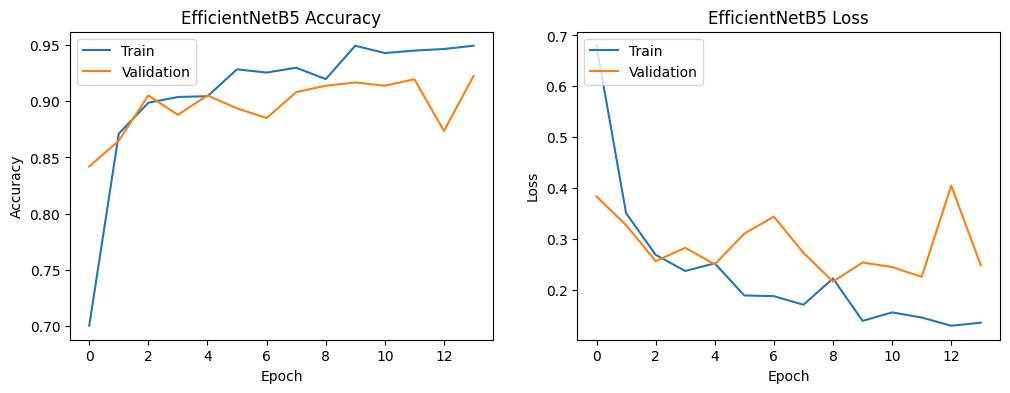

160/160 [==============================] - 18s 96ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      1.00      0.87      1645
        rust       0.81      0.11      0.19       275
        scab       0.60      0.35      0.44       630

    accuracy                           0.74      2550
   macro avg       0.73      0.49      0.50      2550
weighted avg       0.73      0.74      0.69      2550



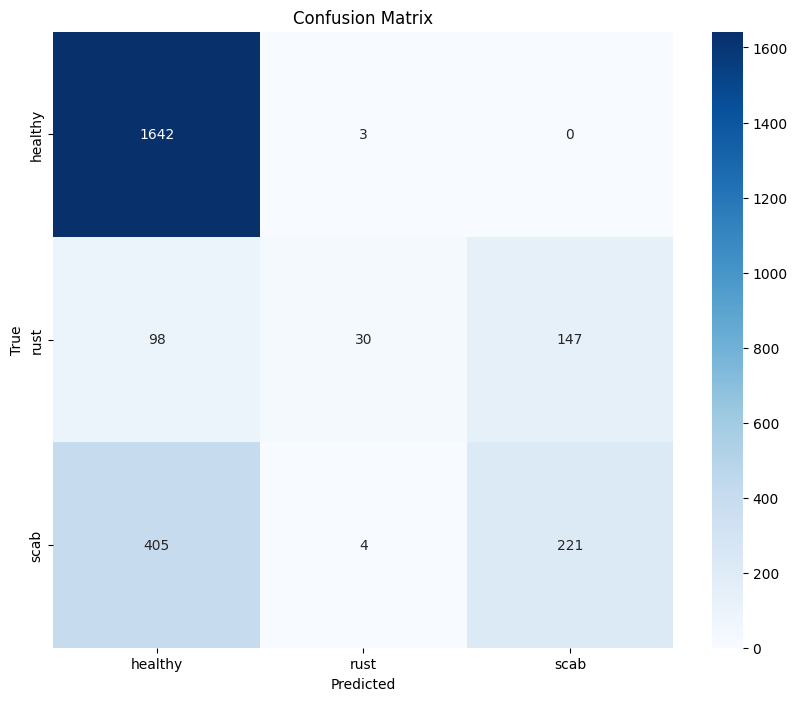

In [36]:
model_name = 'EfficientNetB5'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_not_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5 = train_and_plot(EN_B5, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B5, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
165234480/165234480 [==============================] - 1s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.7062

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 88s 874ms/step - loss: 0.6811 - accuracy: 0.7062 - val_loss: 0.3535 - val_accuracy: 0.8621
Epoch 2/50
87/87 [==============================] - 73s 835ms/step - loss: 0.3708 - accuracy: 0.8596 - val_loss: 0.3587 - val_accuracy: 0.8621
Epoch 3/50
87/87 [==============================] - 73s 844ms/step - loss: 0.2917 - accuracy: 0.8929 - val_loss: 0.2516 - val_accuracy: 0.9023
Epoch 4/50
87/87 [==============================] - 72s 822ms/step - loss: 0.2879 - accuracy: 0.8958 - val_loss: 0.2448 - val_accuracy: 0.9023
Epoch 5/50
87/87 [==============================] - 74s 846ms/step - loss: 0.2239 - accuracy: 0.9117 - val_loss: 0.2099 - val_accuracy: 0.9224
Epoch 6/50
87/87 [==============================] - 73s 835ms/step - loss: 0.1901 - accuracy: 0.9269 - val_loss: 0.2355 - val_accuracy: 0.9080
Epoch 7/50
87/87 [==============================] - 75s 857ms/step - loss: 0.1814 - accuracy: 0.9247 - val_loss: 0.2449 - val_accuracy: 0.9052
Epoch 8/50

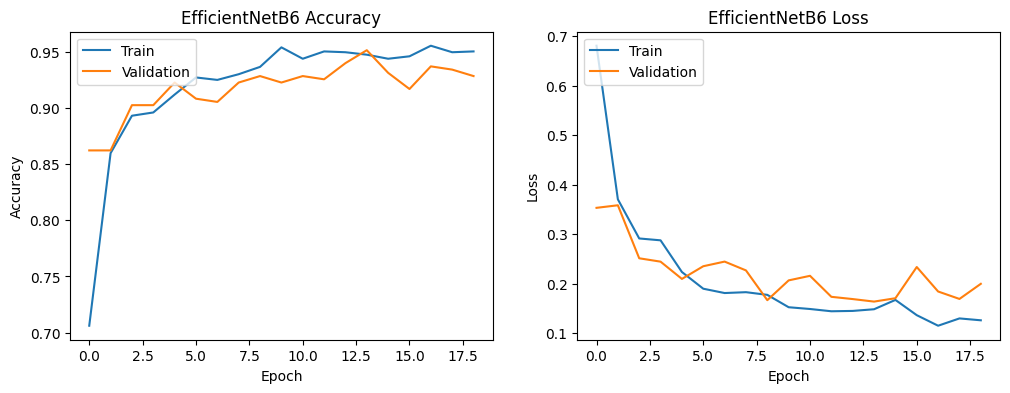

160/160 [==============================] - 27s 151ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.86      0.91      0.88      1645
        rust       0.29      0.02      0.03       275
        scab       0.51      0.65      0.57       630

    accuracy                           0.75      2550
   macro avg       0.55      0.52      0.50      2550
weighted avg       0.71      0.75      0.71      2550



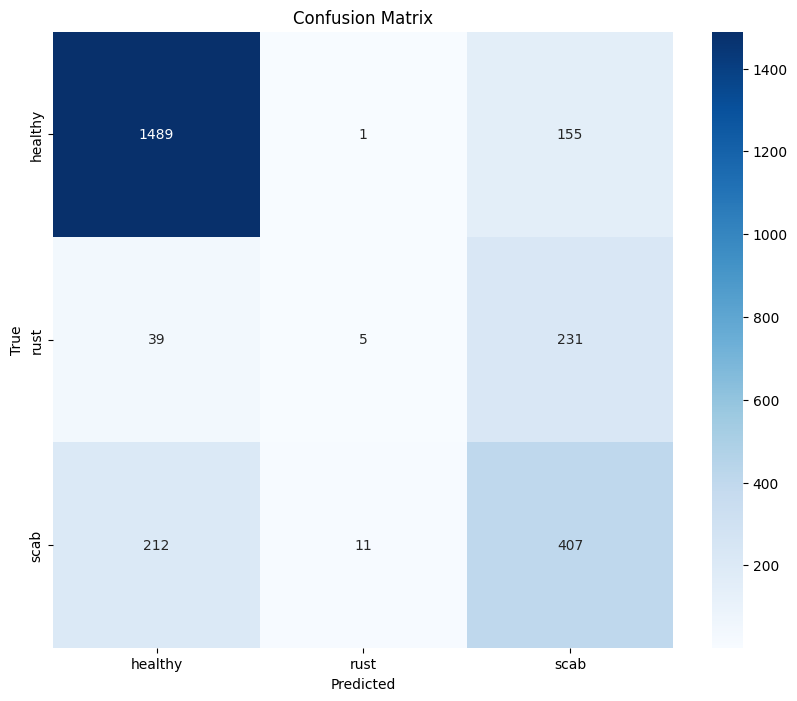

In [37]:
model_name = 'EfficientNetB6'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B6 = build_and_compile_model_not_trainable(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B6 = train_and_plot(EN_B6, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B6, test_generator)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
258076736/258076736 [==============================] - 2s 0us/step
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.6397

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 110s 1s/step - loss: 0.7960 - accuracy: 0.6397 - val_loss: 0.5306 - val_accuracy: 0.7989
Epoch 2/50
87/87 [==============================] - 95s 1s/step - loss: 0.4163 - accuracy: 0.8466 - val_loss: 0.3878 - val_accuracy: 0.8448
Epoch 3/50
87/87 [==============================] - 91s 1s/step - loss: 0.3292 - accuracy: 0.8878 - val_loss: 0.3020 - val_accuracy: 0.8793
Epoch 4/50
87/87 [==============================] - 93s 1s/step - loss: 0.2650 - accuracy: 0.8994 - val_loss: 0.2534 - val_accuracy: 0.9253
Epoch 5/50
87/87 [==============================] - 91s 1s/step - loss: 0.2411 - accuracy: 0.9117 - val_loss: 0.3375 - val_accuracy: 0.8764
Epoch 6/50
87/87 [==============================] - 93s 1s/step - loss: 0.2020 - accuracy: 0.9226 - val_loss: 0.2507 - val_accuracy: 0.9138
Epoch 7/50
87/87 [==============================] - 92s 1s/step - loss: 0.1941 - accuracy: 0.9233 - val_loss: 0.2590 - val_accuracy: 0.9023
Epoch 8/50
87/87 [============

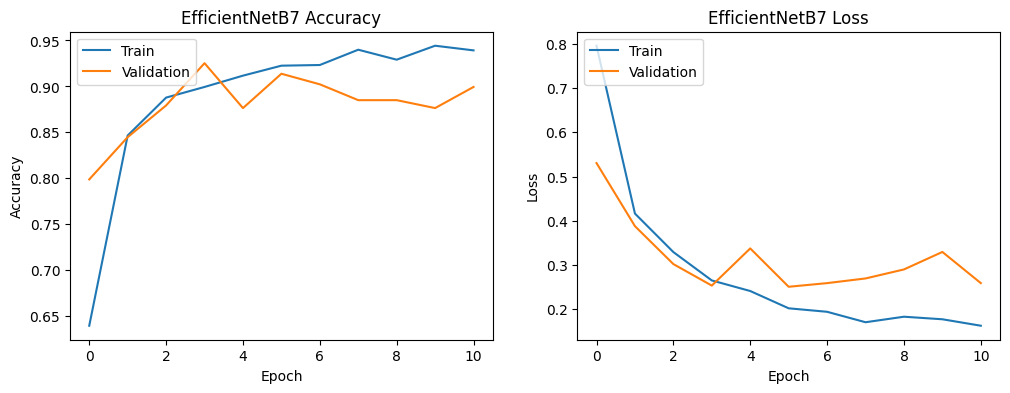

160/160 [==============================] - 44s 254ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.93      0.64      0.76      1645
        rust       0.60      0.01      0.02       275
        scab       0.39      0.87      0.54       630

    accuracy                           0.63      2550
   macro avg       0.64      0.51      0.44      2550
weighted avg       0.76      0.63      0.62      2550



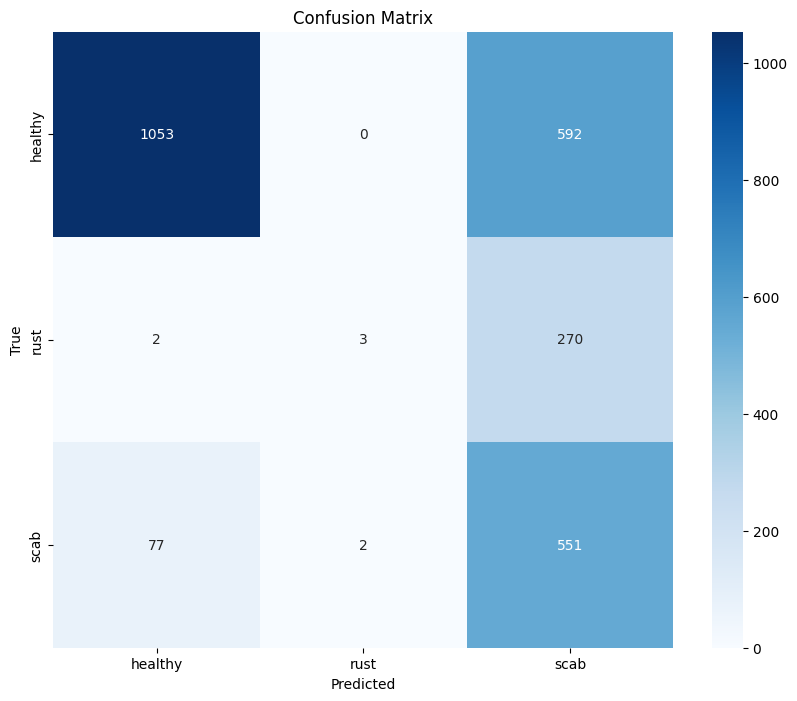

In [38]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B7 = build_and_compile_model_not_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B7 = train_and_plot(EN_B7, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model/')
evaluate_and_plot_confusion_matrix(EN_B7, test_generator)

In [ ]:
#TRAINABLE
#TRAINABLE
#TRAINABLE
#TRAINABLE

In [41]:
# Evaluasi model setelah pelatihan
test_loss, test_accuracy = EN_TEST.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

160/160 [==============================] - 48s 259ms/step - loss: 1.1553 - accuracy: 0.1039
Test Accuracy: 0.1039


In [ ]:
model_name = 'EfficientNetB0'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B0 = build_and_compile_model_trainable(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B0 = train_and_plot(EN_B0, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B0, test_generator)

In [ ]:
model_name = 'EfficientNetB1'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B1 = build_and_compile_model_trainable(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B1 = train_and_plot(EN_B1, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B1, test_generator)

In [ ]:
model_name = 'EfficientNetB2'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B2 = build_and_compile_model_trainable(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B2 = train_and_plot(EN_B2, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B2, test_generator)

In [ ]:
model_name = 'EfficientNetB3'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B3 = build_and_compile_model_trainable(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B3 = train_and_plot(EN_B3, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B3, test_generator)

In [ ]:
model_name = 'EfficientNetB4'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B4 = build_and_compile_model_trainable(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B4 = train_and_plot(EN_B4, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B4, test_generator)

In [ ]:
model_name = 'EfficientNetB5'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B5 = build_and_compile_model_trainable(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B5 = train_and_plot(EN_B5, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B5, test_generator)

In [ ]:
model_name = 'EfficientNetB6'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B6 = build_and_compile_model_trainable(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B6 = train_and_plot(EN_B6, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B6, test_generator)

In [ ]:
model_name = 'EfficientNetB7'

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=16,
    preprocess_input_func=preprocess_input_func
)

EN_B7 = build_and_compile_model_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_EN_B7 = train_and_plot(EN_B7, model_name, train_generator, validation_generator, epochs = 50, save_directory='best_model_trainable/')
evaluate_and_plot_confusion_matrix(EN_B7, test_generator)